Plot out PID figures of LC model with various Lambda or NGD model with various beta.

# import and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from matplotlib.ticker import MaxNLocator
import os
%matplotlib inline

In [5]:
import import_ipynb
os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


# Make LPOU or Load Exp file

In [6]:
dt = 0.01
Tot=300
T=np.arange(dt,Tot,dt)
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
OU = (OU-np.mean(OU))/np.std(OU)

# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, OU)
x = x.astype(float)

x = x.astype(float)
x = (x -np.mean(x))/np.std(x)
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt*3/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
tv = ndimage.gaussian_filter1d(x, sigma=int(t_cor/dt*0.1), order=1, mode='reflect') / dt
v=np.append(0, np.diff(x)/dt)
# v = (v -np.mean(v))/np.std(v)
print(t_cor)

0.908402700276732


In [10]:
Fc_list = [2]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
T = T_list[0]
x = x_list[0]
v = ndimage.gaussian_filter1d(x, sigma=5, order=1, mode='reflect') / dt

x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt*3/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)

# Set $\lambda$s

In [5]:
Lambdas =  np.append(np.arange(0,1.0,0.1),1.0)

# LC model

In [6]:
##response
# Model one: simple estimation
window = [-1,1] # second
Information_list = []
dvInformation_list = []
for Lambda in Lambdas:
    r = (1-Lambda)*x+v*Lambda
    #assign states
#     r = NL(np.mean(r)-r, 0)
#     ratio = sum(r)/T[-1]/12
#     FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
#     rstate, _ = np.histogram(FakeSpike, np.append(0,T))
#     rstate = rstate.astype(int)
    rstate,edge = EqualState(r, 6)
    xstate,edge = EqualState(x, 6)
    vstate,edge = EqualState(v, 6)
    tvstate,edge = EqualState(tv, 6)
    #calculate information
    timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
    timeshift, dvInformation = PIfunc(rstate, xstate, tvstate, dt, window)
    Ux = Information[('Beer','UIx')]
    Uv = Information[('Beer','UIv')]
    Syner = Information[('Beer','Syn')]
    Redun = Information[('Beer','Red')]
    Information_list.append(Information)
    dvInformation_list.append(dvInformation)
#         ax.plot(Ux+Uv+Redun+Syner)

# NGD

In [ ]:
betas = (1-Lambdas)/Lambdas
g = 40.
alpha = 20. #1/sec
K = 23.
phi = 1.

In [ ]:
##response
# Model one: simple estimation
window = [-1,1] # second
Information_list = []
dvInformation_list = []
for beta in betas:
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    for j in range(len(T)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    #assign states
    r = NL(np.mean(y)-y, 0)
    ratio = sum(r)/T[-1]/12
    FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
    rstate, _ = np.histogram(FakeSpike, np.append(0,T))
    rstate = rstate.astype(int)
    
    xstate,edge = EqualState(x, 6)
    vstate,edge = EqualState(v, 6)
    tvstate,edge = EqualState(tv, 6)
    timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
#     timeshift, dvInformation = PIfunc(rstate, xstate, tvstate, dt, window)
    Ux = Information[('Beer','UIx')]
    Uv = Information[('Beer','UIv')]
    Syner = Information[('Beer','Syn')]
    Redun = Information[('Beer','Red')]
    Information_list.append(Information)
#     dvInformation_list.append(dvInformation)
#         ax.plot(Ux+Uv+Redun+Syner)

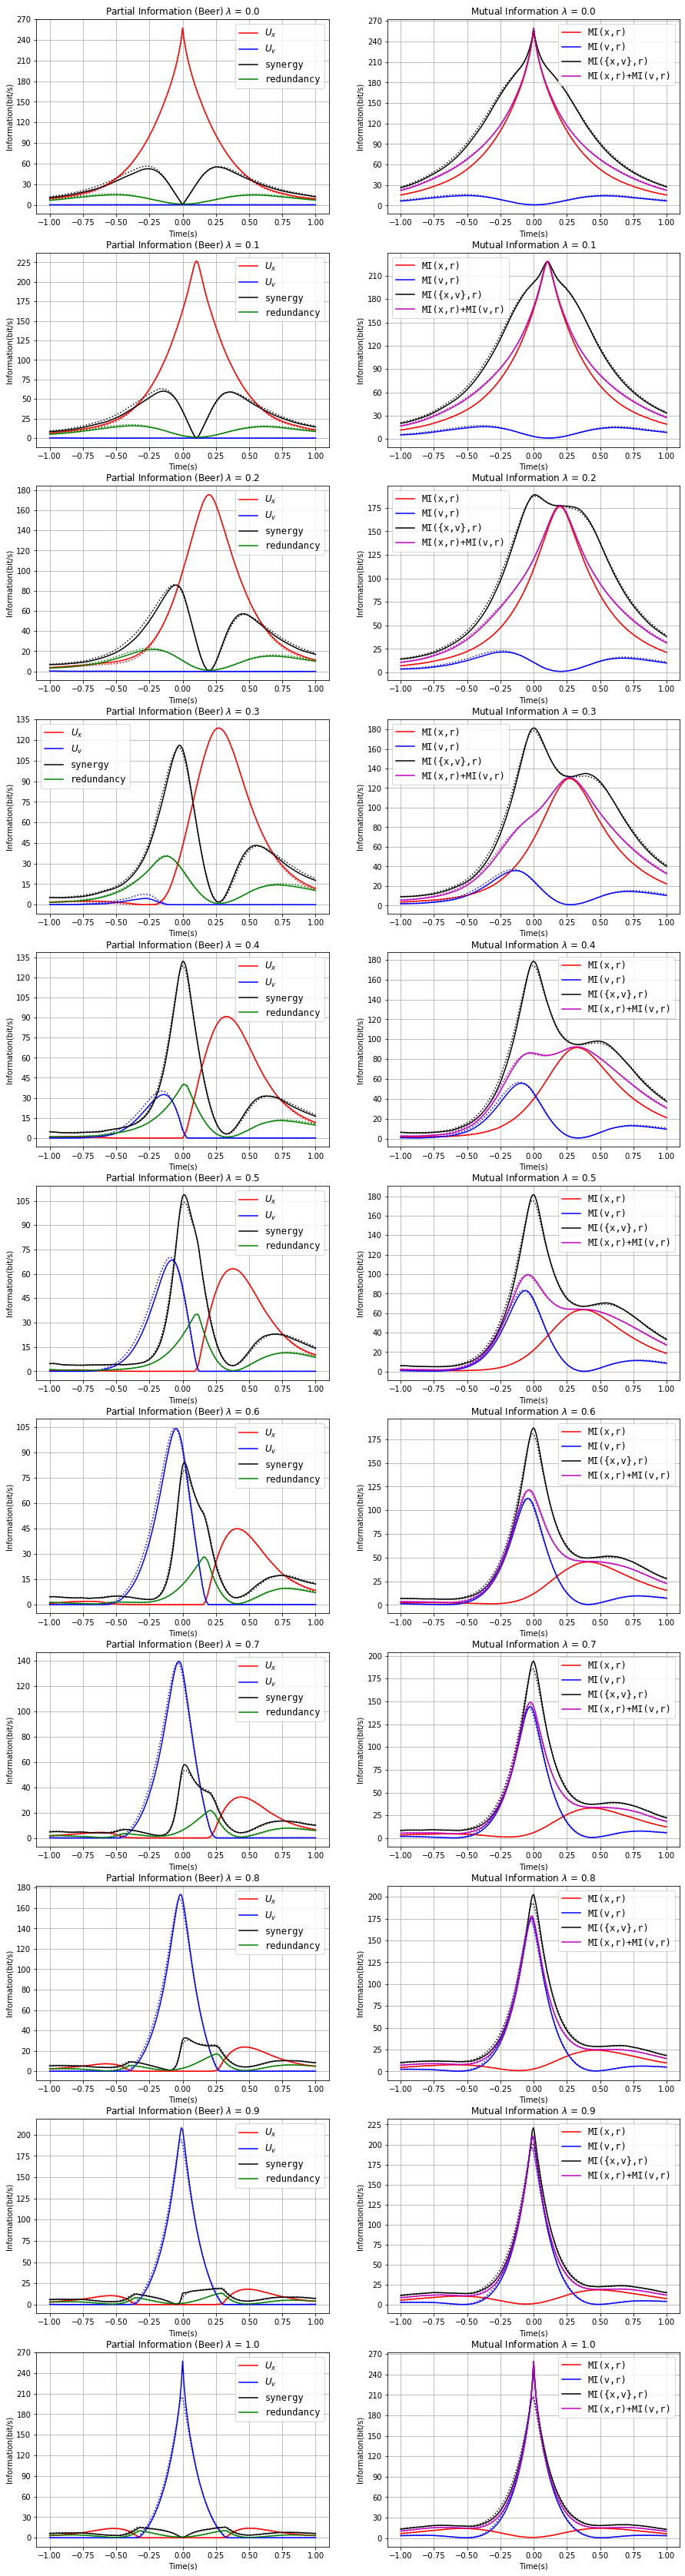

In [7]:
fig, ax = plt.subplots(nrows=len(Information_list), ncols=2)
for i in range(len(Information_list)): 
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    
#     ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','UIx')], 'r:')
#     ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','UIv')], 'b:')
#     ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','Syn')], 'k:')
#     ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','Red')], 'g:')
    ax[i][0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][0].set_title('Partial Information (Beer) '+r'$\lambda$ = '+str(round(Lambdas[i],1)))
    ax[i][0].set_xlabel('Time(s)')
    ax[i][0].set_ylabel('Information(bit/s)')
    ax[i][0].legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i][0].grid()
    
    #plot MIs
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+
                  Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+
                  Information_list[i][('Beer','UIv')], 'm-')
#     ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIx')]+dvInformation_list[i][('Beer','Red')], 'r:')
#     ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIv')]+dvInformation_list[i][('Beer','Red')], 'b:')
#     ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIx')]+dvInformation_list[i][('Beer','Red')]+
#                   dvInformation_list[i][('Beer','UIv')]+dvInformation_list[i][('Beer','Syn')], 'k:')
#     ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIx')]+2*dvInformation_list[i][('Beer','Red')]+
#                   dvInformation_list[i][('Beer','UIv')], 'm:')
    ax[i][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][1].set_title('Mutual Information '+r'$\lambda$ = '+str(round(Lambdas[i],1)))
    ax[i][1].set_xlabel('Time(s)')
    ax[i][1].set_ylabel('Information(bit/s)')
    ax[i][1].grid()
    ax[i][1].legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5.5*len(Information_list))

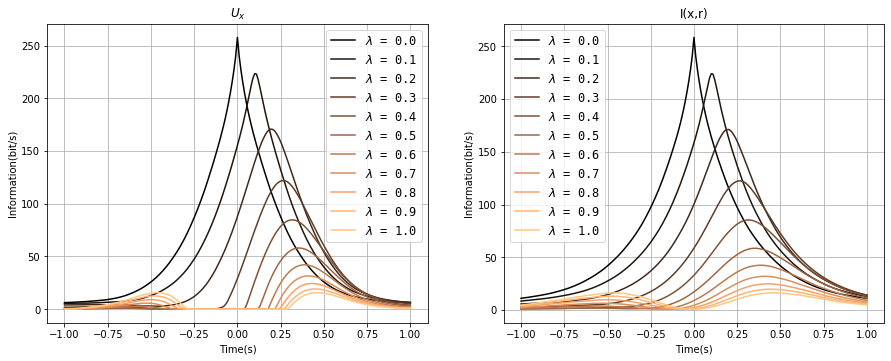

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
ax[1].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
for i in range(len(Information_list)): 
    ax[0].plot(timeshift,Information_list[i][('Beer','UIx')])
    ax[1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
ax[0].set_title(r'$U_x$')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Information(bit/s)')
ax[0].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[0].grid()
ax[1].set_title('I(x,r)')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('Information(bit/s)')
ax[1].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[1].grid()
fig.set_size_inches(15, 5.5)

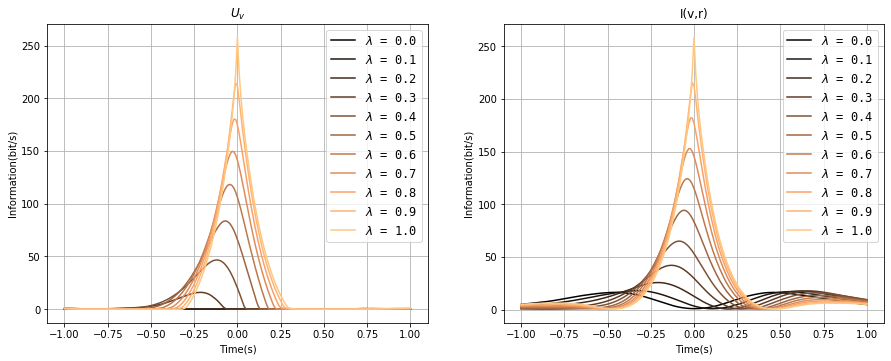

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
ax[1].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
for i in range(len(Information_list)): 
    ax[0].plot(timeshift,Information_list[i][('Beer','UIv')])
    ax[1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
ax[0].set_title(r'$U_v$')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Information(bit/s)')
ax[0].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[0].grid()
ax[1].set_title('I(v,r)')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('Information(bit/s)')
ax[1].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[1].grid()
fig.set_size_inches(15, 5.5)

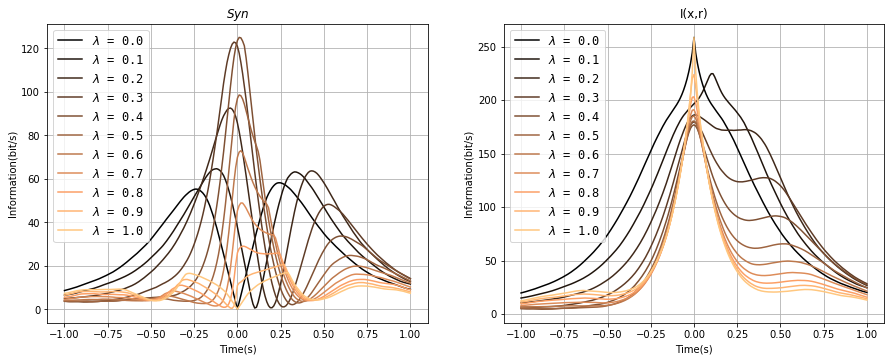

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
ax[1].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
for i in range(len(Information_list)): 
    ax[0].plot(timeshift,Information_list[i][('Beer','Syn')])
#     ax[0].plot(timeshift,Information_list[i][('Beer','Red')], linestyle = 'dashed')
    ax[1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
ax[0].set_title(r'$Syn$')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Information(bit/s)')
ax[0].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[0].grid()
ax[1].set_title('I(x,r)')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('Information(bit/s)')
ax[1].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[1].grid()
fig.set_size_inches(15, 5.5)